<a href="https://colab.research.google.com/github/songseunghei/DeepLearning/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 15.1 MB/s eta 0:00:00


In [2]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import os
import random
import cv2 as cv

import tensorflow_datasets as tfds
tfds.disable_progress_bar()
tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


({'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
  'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>},
 tfds.core.DatasetInfo(
     name='oxford_iiit_pet',
     full_name='oxford_iiit_pet/3.2.0',
     description="""
     The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
     images for each class. The images ha

In [8]:
input_dir='/root/tensorflow_datasets/downloads/extracted/images/'
target_dir='/root/tensorflow_datasets/downloads/extracted/annotations/trimaps/'
img_size=(160,160)
n_class = 3
batch_size = 32
img_paths = sorted([os.path.join(input_dir,f) for f in os.listdir(input_dir) if f.endswith('.jpg')])
label_paths= sorted([os.path.join(target_dir,f) for f in os.listdir(target_dir) if f.endswith('.png') and not f.startswith('.')])

In [9]:
class OxfordPets(keras.utils.Sequence):
  def __init__(self,batch_size,img_size,img_paths,label_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.img_paths = img_paths
    self.label_paths = label_paths
  def __len__(self):
    return len(self.label_paths)//self.batch_size

  def __getitem__(self,idx):
    i=idx*self.batch_size
    batch_img_paths = self.img_paths[i:i+self.batch_size]
    batch_label_paths = self.label_paths[i:i+self.batch_size]
    x=np.zeros((self.batch_size,)+self.img_size+(3,),dtype="float32")
    for j,path in enumerate(batch_img_paths):
      img=load_img(path, target_size=self.img_size)
      x[j]=img
    y=np.zeros((self.batch_size,)+self.img_size+(1,),dtype="uint8")
    for j,path in enumerate(batch_label_paths):
      img=load_img(path,target_size = self.img_size, color_mode="grayscale")
      y[j]=np.expand_dims(img,2)
      y[j]-=1
    return x,y

In [10]:
def conv2d_block(input_tensor, n_filters,kernel_size=3):
  x=input_tensor
  for i in range(2):
    x = layers.SeparableConv2D(filters = n_filters, kernel_size=(kernel_size, kernel_size),
                               kernel_initializer = 'he_normal', padding='same')(x)
    x=layers.Activation('relu')(x)
    return x

In [11]:
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  f=conv2d_block(inputs,n_filters=n_filters)
  p=layers.MaxPooling2D(pool_size = (2,2))(f)
  p=layers.Dropout(0.3)(p)
  return f,p

In [20]:
def encoder(inputs):
  f1,p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2,p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3,p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4,p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)
  return p4, (f1,f2,f3,f4)

In [13]:
def bottleneck(inputs):
  bottle_neck = conv2d_block(inputs,n_filters=1024)
  return bottle_neck

In [14]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  u=layers.Conv2DTranspose(n_filters,kernel_size, strides=strides, padding='same')(inputs)
  c=layers.concatenate([u, conv_output])
  c=layers.Dropout(dropout)(c)
  c=conv2d_block(c, n_filters,kernel_size=3)
  return c

In [22]:
import tensorflow as tf
def decoder(inputs,convs, output_channels):
  f1,f2,f3,f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  outputs=tf.keras.layers.Conv2D(output_channels, (1,1), activation='softmax')(c9)
  return outputs

In [18]:
def make_model(img_size, num_classes):
  inputs=keras.Input(shape=img_size+(3,))
  encoder_output, convs=encoder(inputs)
  bottle_neck = bottleneck(encoder_output)
  outputs=decoder(bottle_neck, convs, 3)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

Epoch 1/20
184/184 [==============================] - 114s 587ms/step - loss: 0.8871 - accuracy: 0.1735 - val_loss: 0.7441 - val_accuracy: 0.2386
Epoch 2/20
184/184 [==============================] - 108s 585ms/step - loss: 0.6448 - accuracy: 0.3232 - val_loss: 0.5793 - val_accuracy: 0.3315
Epoch 3/20
184/184 [==============================] - 108s 585ms/step - loss: 0.5411 - accuracy: 0.3147 - val_loss: 0.5148 - val_accuracy: 0.3819
Epoch 4/20
184/184 [==============================] - 108s 585ms/step - loss: 0.4811 - accuracy: 0.3154 - val_loss: 0.4429 - val_accuracy: 0.3223
Epoch 5/20
184/184 [==============================] - 108s 585ms/step - loss: 0.4451 - accuracy: 0.3147 - val_loss: 0.4024 - val_accuracy: 0.3393
Epoch 6/20
184/184 [==============================] - 108s 586ms/step - loss: 0.4217 - accuracy: 0.3138 - val_loss: 0.3988 - val_accuracy: 0.3477
Epoch 7/20
184/184 [==============================] - 107s 584ms/step - loss: 0.4010 - accuracy: 0.3133 - val_loss: 0.3930 -

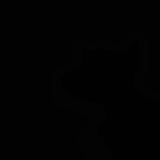

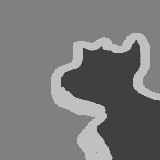

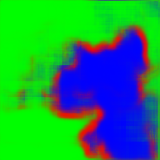

(160, 160, 3)


In [24]:
model = make_model(img_size, n_class)
random.Random(1).shuffle(img_paths)
random.Random(1).shuffle(label_paths)
test_samples=int(len(img_paths)*0.2)
train_img_paths = img_paths[:-test_samples]
train_label_paths = label_paths[:-test_samples]
test_img_paths = img_paths[:-test_samples:]
test_label_paths = label_paths[:-test_samples:]

train_gen= OxfordPets(batch_size, img_size, train_img_paths, train_label_paths)
test_gen = OxfordPets(batch_size,img_size, test_img_paths, test_label_paths)

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
cb = [keras.callbacks.ModelCheckpoint('oxford_seg.h5', save_best_only=True)]
model.fit(train_gen,epochs=20, validation_data = test_gen, callbacks=cb)
from google.colab.patches import cv2_imshow
preds = model.predict(test_gen) #예측
img = cv.imread(test_label_paths[1])
img= cv.resize(img, (160,160))
cv2_imshow(img)
label = cv.imread(test_label_paths[1])
label = cv.resize(label,(160,160))

cv2_imshow(label*64)
cv2_imshow(preds[1]*255)
cv.waitKey()
cv.destroyAllWindows()
print(preds[1].shape)